## Import modules

In [1]:
import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import session_info
session_info.show()

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'RdPu',)

## Directory

In [5]:
adata_dir = '/nfs/team205/heart/anndata_objects/8regions'

## Read in data

In [7]:
adata = sc.read_h5ad(f'{adata_dir}/QC/multiome_RNA_adult_new-SAN-AVN.h5ad')

# tidy up .var
adata.var=adata.var[['gene_name']]

adata

AnnData object with n_obs × n_vars = 94964 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_name'
    obsm: 'latent_gene_encoding'

## Pre-process

In [8]:
# preserve raw count
adata.layers["counts"] = adata.X.copy()

# filter genes
sc.pp.filter_genes(adata, min_cells=3)

# normalise and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.shape

filtered out 1811 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:01)


(94964, 34790)

## Set batch_key

In [9]:
# combining Donor, Cell_or_Nuclei, and Kit_10X
adata.obs['batch_key']=adata.obs['donor'].astype('str')+'_'+adata.obs['cell_or_nuclei'].astype('str')+'_'+adata.obs['kit_10x'].astype('str')
adata.obs['batch_key'].value_counts()

AH2_Nuclei_Multiome-v1     32259
AV13_Nuclei_Multiome-v1    23009
AV14_Nuclei_Multiome-v1    14674
AV3_Nuclei_Multiome-v1     10755
AV10_Nuclei_Multiome-v1     7957
AH1_Nuclei_Multiome-v1      6310
Name: batch_key, dtype: int64

## hvg identification

extracting highly variable genes
... storing 'batch_key' as categorical
    finished (0:00:15)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


4581


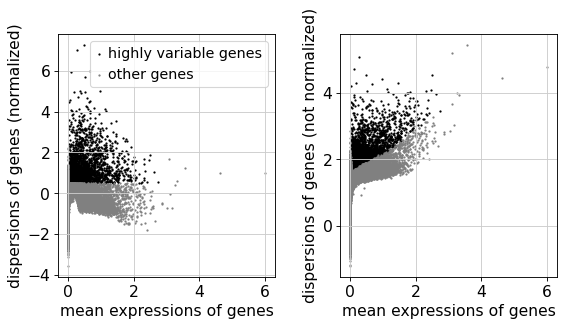

In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key='batch_key')

print(sum(adata.var.highly_variable))
sc.pl.highly_variable_genes(adata)

In [11]:
# freeze the state in `.raw`
adata.raw = adata

In [12]:
# subset hvgs
adata = adata[:, adata.var.highly_variable]

## Save

In [13]:
adata.write(f'{adata_dir}/scVI/multiome_RNA_adult_new-SAN-AVN_pp.h5ad') # batch_key: Donor, Cell_or_Nuclei, and Kit_10X

In [14]:
adata

View of AnnData object with n_obs × n_vars = 94964 × 4581
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch_key'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    obsm: 'latent_gene_encoding'
    layers: 'counts'